# Testing and Evaluating Models

Model evaluation supervised in machine learning revolves around holding back part of the data and seeing how the model deals with it. A model that performs well on new data is a model that can be expected to perform well in production, when all data is new and unlabelled.

Good model evaluation is not just a single test on a single model. A well-tested model is tested many times with different configurations: this is known as hyper-parameter tuning. And a model that is rigorously tested is one that is pitted against other models: linear regression vs. trees vs. SVMs.

It's important to test ML models thoroughly. Machine learning models aren't complete black boxes, but they're certainly more opaque than classic models. Machine learning models don't come with statistical assumptions that let you calculate the standard errors of coefficients, or let you assume that you have the [best estimator possible](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem).

Ultimately, testing machine learning models is fun. This guide covers

* Test-train splits
* k-fold cross-validation
* Validation sets vs. test sets
* Using meaningful test sets
* Extra: standard metrics in scikit-learn

The question we're always trying to answer here is *how well will this model perform in the wild*?

In [1]:
# numpy
import numpy as np

# get scikit-learn's datasets
from sklearn import datasets

# get some model selection tools
from sklearn.model_selection import train_test_split, KFold

# load various models from scikit-learn's library
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# also get some metrics to try
from sklearn.metrics import *
import sklearn.metrics

# matplotlib for graphs
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# itertools
import itertools

## Train-test Splits

In the examples above we evaluated the model's performance by only considering its performance with the training set. Since the model already learns from this data, it's expected to familiar with it. This kind of testing does not give you a reliable idea of how your model will perform with new "real-world" data.

By using a test set kept separate from the model's training, we can get a glimpse of how the model reacts in an unexpected situation. This idea is the basis for most model evaluation in machine learning.

I'll start by showing you the technique of randomized test-train splits, a technique that works in most situations.

Let's use the Boston dataset again.

In [2]:
house_prices = datasets.load_boston()

# Make things a bit cleaner
X = house_prices.data
y = house_prices.target

Scikit-learn's `train_test_split` function will split a dataset for you. Using the `shuffle` option is a good idea if the dataset is sorted in some way and you want a randomized test set (this is the case here).

Set the `random_state` option if you want your code to shuffle the exact same way each time it's run.

If your dataset has duplicates, they should be removed since otherwise some data will be in both the training set and the test set, making the split imperfect.

In [3]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1234)

print("Training data X shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], X_train.shape)])))
print("Training data y shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], y_train.shape)])))
print("Test data X shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], X_test.shape)])))
print("Test data y shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], y_test.shape)])))

Training data X shape: rows 379; columns 13
Training data y shape: rows 379
Test data X shape: rows 127; columns 13
Test data y shape: rows 127


Thanks to the magic of scikit-learn, I can evaluate the train-test split on many different models quickly.

This is an important part of machine learning model evaluation, and you'll see me apply this technique repeatedly: **see how your type of model compares against other types of models**.

OLS                  training R^2  0.73, test R^2  0.73
KNN                  training R^2  0.66, test R^2  0.55
DecisionTrees        training R^2  1.00, test R^2  0.84
AdaBoost             training R^2  0.91, test R^2  0.86
Random Forests       training R^2  0.97, test R^2  0.89
GradientBoost        training R^2  0.98, test R^2  0.91


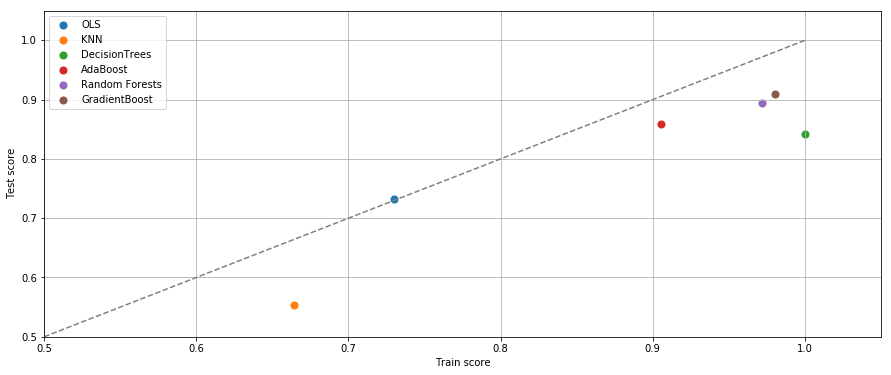

In [4]:
regressors = {"OLS" : LinearRegression(), 
              "KNN" : KNeighborsRegressor(), 
              "DecisionTrees" : DecisionTreeRegressor(), 
              "AdaBoost" : AdaBoostRegressor(random_state=1234), 
              "Random Forests" : RandomForestRegressor(random_state=1234), 
              "GradientBoost" : GradientBoostingRegressor(random_state=1234)
             }

fig, ax = plt.subplots(figsize=(15, 6))

# You can use the zip() function to iterate over multiple series
for name, regressor in regressors.items():
    model = regressor
    # fit instance
    fit = model.fit(X=X_train, y=y_train)
    # R^2
    train_score = r2_score(y_true = y_train, y_pred = model.predict(X=X_train))
    test_score = r2_score(y_true = y_test, y_pred = model.predict(X=X_test))
    
    # print results
    print("{:<20} training R^2 {:5.2f}, test R^2 {:5.2f}".format(name, train_score, test_score))
    
    ax.scatter(train_score, test_score, s=50, label=name)


ax.legend()
ax.axis((0.5, 1.05, 0.5, 1.05))
ax.grid(True)
ax.add_line(lines.Line2D([0.5, 1], [0.5, 1], c="grey", ls="--"))
plt.xlabel("Train score")
plt.ylabel("Test score")
plt.show()

A higher test score is better. We can see below that the ensemble methods ([AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor), [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), [GradientBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)) generally beat the other models. While ensemble models are usually pretty good, there may be some rare situation where OLS performs the best: comparing models is easy and it helps a lot.

The relationship between training score and validation score are **important** for determining overfit and underfit, and you should always check this.

* A training score much higher than the validation score means overfitting
* A training score and a validation score similar in value indicates good generalization
    * However a model with both low training and low validation scores likely has trouble modelling the data
* A validation score higher than the training score is evidence of either underfitting or a bug in the model

Note that if you're performing multi-class classification over a lot of classes, your accuracy is bound to be lower (it's harder to get the right 1 out of 1000).

It can be worthwhile to visualize your results. Below are graphs showing the errors/residuals along the `AGE` variable. You may sometimes suspect something strange is happening with your models, and a library like `matplotlib` makes the oddities stand out.

*** Error along feature values ***
---
Quintile ranges for AGE: Q1 6.0 to 36.1; Q2 37.8 to 63.0; Q3 64.5 to 89.0; Q4 89.1 to 95.8; Q5 96.0 to 100.0
---
OLS            QU mean/std [-2.35/ 5.06], [ 0.40/ 4.48], [-0.97/ 4.75], [ 0.14/ 4.41], [-0.33/ 6.53]; all [-0.63/ 5.19]
KNN            QU mean/std [ 0.53/ 7.28], [-0.16/ 5.07], [-2.39/ 7.81], [ 0.11/ 5.36], [-0.28/ 7.33]; all [-0.43/ 6.74]
DecisionTrees  QU mean/std [-1.35/ 2.83], [ 0.67/ 3.76], [ 1.04/ 4.19], [-0.26/ 3.23], [ 1.03/ 4.95]; all [ 0.22/ 3.97]
AdaBoost       QU mean/std [ 0.58/ 2.73], [ 0.63/ 3.86], [ 0.82/ 4.13], [-0.50/ 2.29], [ 0.29/ 5.14]; all [ 0.37/ 3.79]
Random Forests QU mean/std [-0.24/ 1.65], [ 0.45/ 3.40], [ 0.07/ 3.54], [-0.18/ 2.12], [ 0.20/ 4.79]; all [ 0.06/ 3.29]
GradientBoost  QU mean/std [ 0.29/ 1.66], [ 0.36/ 3.13], [ 0.42/ 3.57], [-0.42/ 2.04], [-0.09/ 4.02]; all [ 0.12/ 3.03]


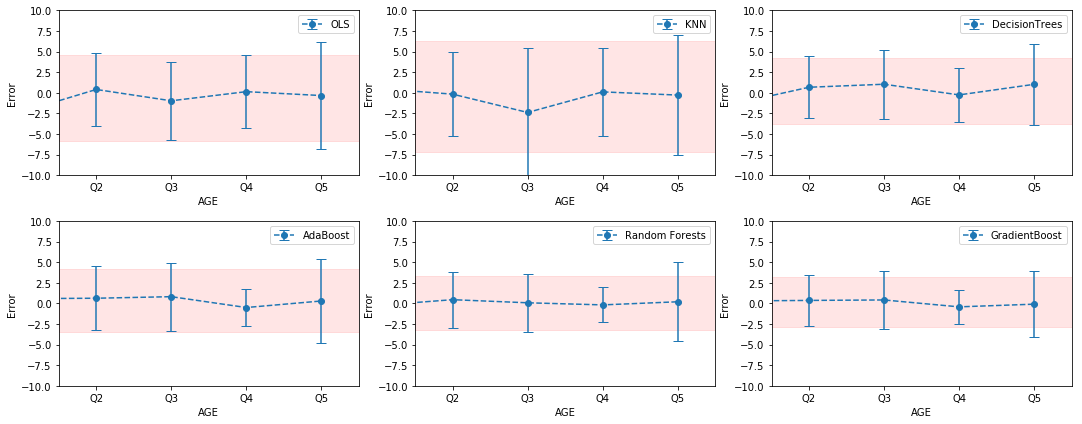

In [5]:
regressors = {"OLS" : LinearRegression(), 
              "KNN" : KNeighborsRegressor(), 
              "DecisionTrees" : DecisionTreeRegressor(), 
              "AdaBoost" : AdaBoostRegressor(random_state=1234), 
              "Random Forests" : RandomForestRegressor(random_state=1234), 
              "GradientBoost" : GradientBoostingRegressor(random_state=1234)
             }

error_dict = {}
score_dict = {}

# You can use the zip() function to iterate over multiple series
for name, regressor in regressors.items():
    model = regressor
    # fit instance
    fit = model.fit(X=X_train, y=y_train)
    # score
    score_dict[name] = r2_score(y_true = y_test, y_pred = model.predict(X=X_test))
    # errors
    error_dict[name] = model.predict(X=X_test) - y_test

print("*** Error along feature values ***")
print("---")
for i in [6]:
    plt.figure(figsize=(15, 6))
    i_name = house_prices["feature_names"][i]
    i_data = np.expand_dims(X_test[:, i], axis=1)
    cbind = np.hstack([i_data] + [error_dict[key].reshape(-1, 1) for key in error_dict.keys()])
    cbind = cbind[cbind[:,0].argsort()]
    err_mean = np.mean(cbind[:,1:], axis=0)
    err_std = np.std(cbind[:,1:], axis=0)
    quintile_data = np.array_split(cbind, 5)
    quintile_min = [min(i[:,0]) for i in quintile_data]
    quintile_max = [max(i[:,0]) for i in quintile_data]
    print("Quintile ranges for {0}: {1}".format(
        i_name, "; ".join(["Q{0} {1} to {2}".format(a+1, b, c) for a, b, c in zip(range(5), quintile_min, quintile_max)]))
         )
    print("---")
    q_err_means = [np.mean(i[:,1:], axis=0) for i in quintile_data]
    q_err_stds = [np.std(i[:,1:], axis=0) for i in quintile_data]
    for k, key in zip(range(len(error_dict.keys())), error_dict.keys()):
        print("{:<15}QU mean/std {:}; all [{:5.2f}/{:5.2f}]".format(
            key, 
            ", ".join(["[{:5.2f}/{:5.2f}]".format(m[k], s[k]) for m, s in zip(q_err_means, q_err_stds)]), 
            err_mean[k], 
            err_std[k])
        )
        plt.subplot(2, 3, k+1)
        plt.errorbar(list(map(lambda s: "Q"+str(s), range(1, 5+1))), 
                     list(map(lambda m: m[k], q_err_means)), 
                     list(map(lambda m: m[k], q_err_stds)), 
                     label=key, 
                     fmt='--o', 
                     capsize=5)
        plt.axhspan(err_mean[k]-err_std[k], err_mean[k]+err_std[k], alpha=0.1, color='red')
        plt.xlabel(i_name)
        plt.ylabel("Error")
        plt.axis((0.5, 4.5, -10, 10))
        plt.legend()
    plt.tight_layout()
    plt.show()

## k-fold cross-validation

Train-test splits are nice but they omit something important: the stability of model performance over different datasets. A high score may be nice, but it's worthless if it merely comes from a lucky draw. We don't want to let the models win the lottery, in other words.

k-fold cross-validation works by peforming the train-test split `k` times. For each fold, the performance of the model is measured, and afterwards the mean and the variance of these measures are looked at.

Below you can better see how the models compare.

1. The OLS model has fluctuating scores and seems to inderfit.
2. KNN has the worst performance.
3. DecisionTrees overfit.

The ensemble methods all work well, but GradientBoost is the best overall.

OLS                  training R^2s  0.73,  0.75,  0.73,  0.73,  0.79 (mean  0.74 stdev  0.03)
OLS                      test R^2s  0.77,  0.62,  0.78,  0.79,  0.49 (mean  0.69 stdev  0.12)
OLS             train^2 - test R^2 -0.04,  0.13, -0.05, -0.06,  0.30 (mean  0.05)

KNN                  training R^2s  0.67,  0.71,  0.67,  0.71,  0.72 (mean  0.69 stdev  0.02)
KNN                      test R^2s  0.56,  0.52,  0.69,  0.43,  0.39 (mean  0.52 stdev  0.11)
KNN             train^2 - test R^2  0.11,  0.18, -0.02,  0.28,  0.33 (mean  0.18)

DecisionTrees        training R^2s  1.00,  1.00,  1.00,  1.00,  1.00 (mean  1.00 stdev  0.00)
DecisionTrees            test R^2s  0.79,  0.66,  0.66,  0.88,  0.55 (mean  0.71 stdev  0.12)
DecisionTrees   train^2 - test R^2  0.21,  0.34,  0.34,  0.12,  0.45 (mean  0.29)

AdaBoost             training R^2s  0.90,  0.92,  0.91,  0.90,  0.91 (mean  0.91 stdev  0.01)
AdaBoost                 test R^2s  0.85,  0.80,  0.82,  0.87,  0.69 (mean  0.81 stdev  0.06)

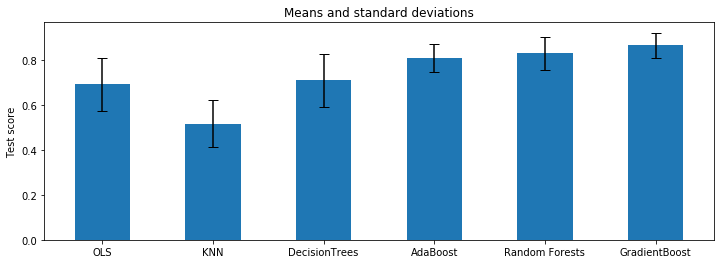

In [6]:
regressors = {"OLS" : LinearRegression(), 
              "KNN" : KNeighborsRegressor(), 
              "DecisionTrees" : DecisionTreeRegressor(), 
              "AdaBoost" : AdaBoostRegressor(random_state=1234), 
              "Random Forests" : RandomForestRegressor(random_state=1234), 
              "GradientBoost" : GradientBoostingRegressor(random_state=1234)
             }

kf = KFold(n_splits = 5, random_state=1234, shuffle=True)

names, means, stds = [], [], []

for name, regressor in regressors.items():
    train_r2s = []
    test_r2s = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = regressor
        # fit instance
        fit = model.fit(X=X_train, y=y_train)
        # R^2
        train_r2s.append(r2_score(y_true = y_train, y_pred = model.predict(X=X_train)))
        test_r2s.append(r2_score(y_true = y_test, y_pred = model.predict(X=X_test)))
    mean_train_r2s = np.mean(train_r2s, axis=0)
    stdev_train_r2s = np.std(train_r2s, axis=0)
    mean_test_r2s = np.mean(test_r2s, axis=0)
    stdev_test_r2s = np.std(test_r2s, axis=0)
    print("{:<20} training R^2s {:} (mean {:5.2f} stdev {:5.2f})".format(name, ", ".join(["{:5.2f}".format(i) for i in train_r2s]), mean_train_r2s, stdev_train_r2s))
    print("{:<20}     test R^2s {:} (mean {:5.2f} stdev {:5.2f})".format(name, ", ".join(["{:5.2f}".format(i) for i in test_r2s]), mean_test_r2s, stdev_test_r2s))
    print("{:<15} train^2 - test R^2 {:} (mean {:5.2f})".format(name, ", ".join(["{:5.2f}".format(i-j) for i, j in zip(train_r2s, test_r2s)]), mean_train_r2s-mean_test_r2s))
    print()
    # Data for graph
    names.append(name)
    means.append(mean_test_r2s)
    stds.append(stdev_test_r2s)


fig, ax = plt.subplots(figsize=(12, 4))

# pyplot wants index numbers
ind = np.arange(len(names))

bars = ax.bar(ind, means, 0.5, yerr=stds, capsize=5)

plt.ylabel('Test score')
plt.title('Means and standard deviations')
plt.xticks(ind, names)

plt.show()

## Training sets, validation sets, test sets

I am going to give you more precise definitions of the different sets

* Training sets are for training
* Validation sets are for model tweaking, not training
* Test sets are for comparing models, for neither training not tweaking

We need to keep validation sets separate from test sets because of things called **hyper-parameters**. Hyper-parameters are model parameters (such as weights, intercepts, etc) that are not directly estimated by the model; however, these hyper-parameters can be optimized through trial and error. We call this trial an error hyper-parameter searching or hyper-parameter tuning.

Since we're optimizing on the validation sets using brute force, we need to keep the test sets separate. This is why we use train-validation-test splits. You will see examples below.

In [7]:
# Create train/test split
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, shuffle=True, random_state=1234)

We'll perform a grid search of parameters here. A very useful function for this is `itertools.product`, which finds all combinations of items among lists. It's equivalent to a nested for-loop.

With the `RandomForestRegressor` we'll try a ton of different parameters to see which work best.

What you see below is that the models (`n`, `m`) that have the best training scores are not the same that have the best validation or test scores. Looking at these scores, you can better foresee how your models will perform in the real world.

Top 5 according to train_score
    1.  n: 100 / m: sqrt / d: 10 | training R^2  0.98 | valid R^2  0.84 | test R^2  0.85
    2.  n: 100 / m: log2 / d: 10 | training R^2  0.98 | valid R^2  0.84 | test R^2  0.85
    3.  n:  75 / m: sqrt / d: 10 | training R^2  0.97 | valid R^2  0.84 | test R^2  0.85
    4.  n:  75 / m: log2 / d: 10 | training R^2  0.97 | valid R^2  0.84 | test R^2  0.85
    5.  n:  50 / m: sqrt / d: 10 | training R^2  0.97 | valid R^2  0.84 | test R^2  0.85
Top 5 according to valid_score
    1.  n:  25 / m: auto / d:  8 | training R^2  0.96 | valid R^2  0.85 | test R^2  0.87
    2.  n:  50 / m: auto / d:  8 | training R^2  0.97 | valid R^2  0.84 | test R^2  0.86
    3.  n:  75 / m: auto / d:  8 | training R^2  0.97 | valid R^2  0.84 | test R^2  0.86
    4.  n:  75 / m: sqrt / d:  8 | training R^2  0.96 | valid R^2  0.84 | test R^2  0.86
    5.  n:  75 / m: log2 / d:  8 | training R^2  0.96 | valid R^2  0.84 | test R^2  0.86
Top 5 according to test_score
    1.  n:   5 / m

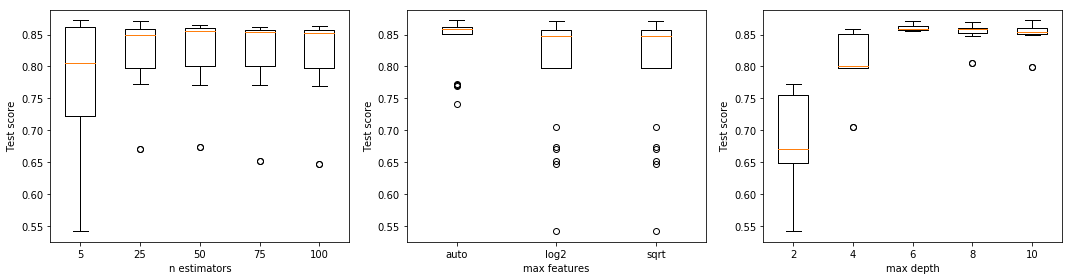

In [8]:
results = []

for n, m, d in itertools.product(
    [5, 25, 50, 75, 100], 
    ["auto", "sqrt", "log2"], 
    [2, 4, 6, 8, 10]
    ):
    model = RandomForestRegressor(n_estimators=n, max_features=m, max_depth=d, random_state=1234)
    # fit instance
    fit = model.fit(X=X_train, y=y_train)
    # R^2
    train_score = r2_score(y_true = y_train, y_pred = model.predict(X=X_train))
    valid_score = r2_score(y_true = y_valid, y_pred = model.predict(X=X_valid))
    test_score = r2_score(y_true = y_test, y_pred = model.predict(X=X_test))
    
    results.append({"n estimators":n, "max features":m, "max depth":d, "train_score":train_score, "valid_score":valid_score, "test_score":test_score})
    
# print results
for score_type in ["train_score", "valid_score", "test_score"]:
    print("Top 5 according to {0}".format(score_type))
    results.sort(key=lambda x: x[score_type], reverse=True)
    i=1
    for row in results:
        print("{:5}.  n: {:3.0f} / m: {:4} / d: {:2} | training R^2 {:5.2f} | valid R^2 {:5.2f} | test R^2 {:5.2f}".format(
            i, row["n estimators"], row["max features"], row["max depth"], 
            row["train_score"], row["valid_score"], row["test_score"]))
        i+=1
        if i > 5: break

# make a graph
# this is a little confusing at first
# pyplot wants a list of lists for boxplots
# each list will be a tick on the x-axis
# the elements within the lists will be rendered into boxes and whiskers by pyplot
fig, ax = plt.subplots(figsize=(15, 4))
for index_number, key in zip(range(3), ["n estimators", "max features", "max depth"]):
    plt.subplot(1, 3, index_number+1)
    # I use set() to get unique x_ticks (values of n estimators, max features, max depth)
    # then I use .sort() to sort them properly (set() randomizes order)
    x_ticks = list(set([i[key] for i in results]))
    x_ticks.sort()
    # I loop through each x_tick and retrieve only the test scores that belong to it
    series = []
    for i in x_ticks:
        series.append([j["test_score"] for j in results if j[key] == i])
    plt.boxplot(series)
    plt.xlabel(key)
    # by default pyplot will display the x labels as integers
    # I replace these with the actual names
    plt.xticks(np.arange(len(x_ticks))+1, x_ticks)
    plt.ylabel("Test score")
    
plt.tight_layout()
plt.show()

### Specific test sets

Randomly selecting your test set can be too easy for your model. Its training and validation sets can have observations that are too closely related to those in the test set, so the model can learn things too easily and give you a false sense of security.

Here is a scenario with the Boston data to illustrate. Suppose we have good data about *most* house prices, but we are suspicious about the prices of homes along the river; perhaps these prices along the river are collected less frequently. How could we measure a model's ability to predict these riverside home prices *without ever seeing the data*? If we were in the business of modeling the missing data, how could we get an idea how well we're doing?

We can split the riverside home prices into our test set and evaluate our model that way. In our Boston dataset, the `CHAS` is the `Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)`.

In [9]:
# CHAS is variable 3
river_indexes = np.flatnonzero(X[:,3] == 1)
river_mask = np.ones(X.shape[0], np.bool)
river_mask[river_indexes] = 0

# Create train/test split
X_, X_test, y_, y_test = X[river_mask,], X[river_indexes,], y[river_mask], y[river_indexes]
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.3)

This is similar to the previous example, except this time I'm randomly trying 2000 different hyper-parameters. I also note the rank of the model to give an idea how its compares.

What you see below gives you an idea of the "hit" to modeling accuracy you'll get if you try to predict riverside house by training on landlocked houses.

Top train_score:  1.00
Top valid_score:  0.93
Top test_score:  0.89
Top 10 results by train_score
    1. lo: lad      / lr: 0.98 / n:  99 / d: 15 | training R^2  1.00 #1    | valid R^2  0.67 #1744 | test R^2  0.58 #1376
    2. lo: lad      / lr: 0.97 / n:  99 / d: 20 | training R^2  1.00 #2    | valid R^2  0.71 #1670 | test R^2  0.81 #28  
    3. lo: ls       / lr: 1.00 / n:  53 / d: 16 | training R^2  1.00 #3    | valid R^2  0.77 #1441 | test R^2  0.69 #381 
    4. lo: ls       / lr: 0.98 / n:   5 / d: 14 | training R^2  1.00 #4    | valid R^2  0.78 #1415 | test R^2  0.42 #1817
    5. lo: ls       / lr: 0.98 / n:  54 / d: 14 | training R^2  1.00 #5    | valid R^2  0.78 #1391 | test R^2  0.43 #1811
    6. lo: ls       / lr: 0.90 / n:  47 / d: 14 | training R^2  1.00 #6    | valid R^2  0.78 #1373 | test R^2  0.44 #1775
    7. lo: ls       / lr: 0.99 / n:  17 / d: 12 | training R^2  1.00 #7    | valid R^2  0.78 #1428 | test R^2  0.45 #1762
    8. lo: ls       / lr: 0.96 / n:  39 / d: 14 

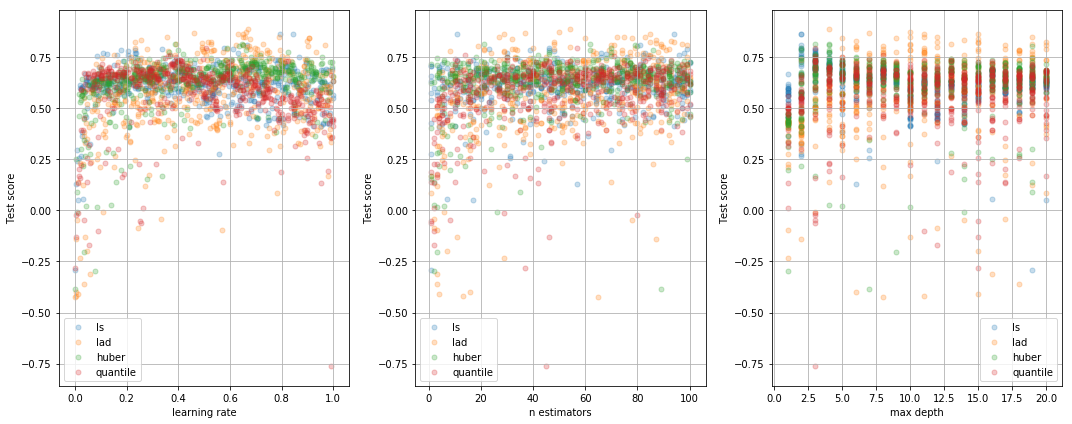

In [10]:
results = []

for i in range(2000):
    #l, n, d in itertools.product(
    #np.random.uniform(low=0.01, high=1.0, size=20), 
    #np.random.randint(5, high=200, size=20), 
    #[1, 2, 3, 4, 5]):
    lo = np.random.choice(["ls", "lad", "huber", "quantile"])
    lr = np.random.ranf()
    n = np.random.randint(1, 100+1)
    d = np.random.choice(np.arange(20)+1)
    model = GradientBoostingRegressor(loss=lo, learning_rate=lr, n_estimators=n, max_depth=d, random_state=1234)
    # fit instance
    fit = model.fit(X=X_train, y=y_train)
    # R^2
    train_score = r2_score(y_true = y_train, y_pred = model.predict(X=X_train))
    valid_score = r2_score(y_true = y_valid, y_pred = model.predict(X=X_valid))
    test_score = r2_score(y_true = y_test, y_pred = model.predict(X=X_test))
    
    results.append({"loss":lo, "learning rate":lr, "n estimators":n, "max depth":d, 
                    "train_score":train_score, "valid_score":valid_score, "test_score":test_score})
    
# rank results
for score_type in ["train_score", "valid_score", "test_score"]:
    results.sort(key=lambda x: x[score_type], reverse=True)
    for i in range(len(results)):
        results[i][score_type+"_rank"] = i+1
    print("Top {:}: {:5.2f}".format(score_type, results[0][score_type]))

# print results
for score_type in ["train_score", "valid_score", "test_score"]:
    print("Top 10 results by {0}".format(score_type))
    results.sort(key=lambda x: x[score_type], reverse=True)
    i=1
    for row in results:
        print("{:5}. lo: {:8} / lr: {:4.2f} / n: {:3.0f} / d: {:} | training R^2 {:5.2f} #{:<4} | valid R^2 {:5.2f} #{:<4} | test R^2 {:5.2f} #{:<4}".format(
            i, row["loss"], row["learning rate"], row["n estimators"], row["max depth"], 
            row["train_score"], row["train_score_rank"], row["valid_score"], row["valid_score_rank"], 
            row["test_score"], row["test_score_rank"]
        ))
        i+=1
        if i > 10: break

# make a graph
fig, ax = plt.subplots(figsize=(15, 6))
for index_number, key in zip(range(4), ["learning rate", "n estimators", "max depth"]):
    plt.subplot(1, 3, index_number+1)
    for loss in ["ls", "lad", "huber", "quantile"]:
        plt.scatter([i[key] for i in results if i["loss"] == loss], 
                    [i["test_score"] for i in results if i["loss"] == loss], s=25, alpha=0.25)
    plt.xlabel(key)
    plt.ylabel("Test score")
    plt.legend(["ls", "lad", "huber", "quantile"])
    plt.grid(True)
    
plt.tight_layout()
plt.show()

## Appendix: standard metrics already in scikit-learn

If you're looking for precision/recall, confusion matrices, and R^2, scikit-learn has all of these and more.

### Classification

First, let's see the classification metrics. Since this is just for fun, I'll create the same kind of fake data as in chapter 2.

In [11]:
# Get a binary classification problem
X, y = datasets.make_moons(n_samples=1000, noise=0.3)

print("Feature data shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], X.shape)])))
print("Target data shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], y.shape)])))

Feature data shape: rows 1000; columns 2
Target data shape: rows 1000


Herea re all of scikit-learns's [classfication metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). I've just copy-pasted there here into a dictionary. The reason I did this is that I'll be able to iterate over this dictionary to try all of the metrics at once.

In [12]:
classification_metrics = {"precision_recall_curve" : "Compute precision-recall pairs for different probability thresholds", 
                            "roc_curve" : "Compute Receiver operating characteristic (ROC)", 
                            "cohen_kappa_score" : "Cohen’s kappa: a statistic that measures inter-annotator agreement.", 
                            "confusion_matrix" : "Compute confusion matrix to evaluate the accuracy of a classification", 
                            "hinge_loss" : "Average hinge loss (non-regularized)", 
                            "matthews_corrcoef" : "Compute the Matthews correlation coefficient (MCC)", 
                            "accuracy_score" : "Accuracy classification score.", 
                            "classification_report" : "Build a text report showing the main classification metrics", 
                            "f1_score" : "Compute the F1 score, also known as balanced F-score or F-measure", 
                            "hamming_loss" : "Compute the average Hamming loss.", 
                            "jaccard_similarity_score" : "Jaccard similarity coefficient score", 
                            "log_loss" : "Log loss, aka logistic loss or cross-entropy loss.", 
                            "precision_recall_fscore_support" : "Compute precision, recall, F-measure and support for each class", 
                            "precision_score" : "Compute the precision", 
                            "recall_score" : "Compute the recall", 
                            "zero_one_loss" : "Zero-one classification loss.", 
                            "average_precision_score" : "Compute average precision (AP) from prediction scores", 
                            "roc_auc_score" : "Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores."
                         }

With a bit of awkward python code, I can call each of the metrics from the `sklearn.metrics` library and see their results.

I think the most useful ones below are the [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) (precision+recall+f1), the [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) and the [accuracy score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score). The accuracy score is the most frequently used of all because it's a single value.

If you are working on a classification task with more than two labels, it's a really good idea to look at the confusion matrix. It will tell you if your model favors certain classes over others.

In [13]:
model = LogisticRegression()
# fit instance
fit = model.fit(X=X, y=y)

for key, value in classification_metrics.items():
    print("*** {0} ***".format(key))
    print(value)
    print(getattr(sklearn.metrics, key)(y, model.predict(X=X)))
    print("---")

*** precision_recall_curve ***
Compute precision-recall pairs for different probability thresholds
(array([ 0.5      ,  0.8608871,  1.       ]), array([ 1.   ,  0.854,  0.   ]), array([0, 1]))
---
*** roc_curve ***
Compute Receiver operating characteristic (ROC)
(array([ 0.   ,  0.138,  1.   ]), array([ 0.   ,  0.854,  1.   ]), array([2, 1, 0]))
---
*** cohen_kappa_score ***
Cohen’s kappa: a statistic that measures inter-annotator agreement.
0.716
---
*** confusion_matrix ***
Compute confusion matrix to evaluate the accuracy of a classification
[[431  69]
 [ 73 427]]
---
*** hinge_loss ***
Average hinge loss (non-regularized)
0.642
---
*** matthews_corrcoef ***
Compute the Matthews correlation coefficient (MCC)
0.7160229131
---
*** accuracy_score ***
Accuracy classification score.
0.858
---
*** classification_report ***
Build a text report showing the main classification metrics
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       500
 

### Digression: confusion matrix multi-class classification

It's worth seeing the usefulness of the confusion matrix with an example. The confusion matrix will inform you how well your model is doing on each class, so you can see if it's giving unequal attention to the data.

In [14]:
# Get the iris data
X, y = datasets.load_iris().data, datasets.load_iris().target

print("Feature data shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], X.shape)])))
print("Target data shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], y.shape)])))

model = LogisticRegression()
# fit instance
fit = model.fit(X=X, y=y)

print("Classification report:")
print(classification_report(y, model.predict(X=X)))

print("Confusion matrix:")
print(confusion_matrix(y, model.predict(X=X)))

Feature data shape: rows 150; columns 4
Target data shape: rows 150
Classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.98      0.90      0.94        50
          2       0.91      0.98      0.94        50

avg / total       0.96      0.96      0.96       150

Confusion matrix:
[[50  0  0]
 [ 0 45  5]
 [ 0  1 49]]


To read the confusion matrix, you need to know how the columns and rows correspond to the labels.

In [15]:
print(datasets.load_iris().target_names)

['setosa' 'versicolor' 'virginica']


Along the columns (horizontally) are the predicted classes from the model, and along the rows (vertically) are the actual classes from the data. For example, the model incorrectly classified 5 versicolor as virginica (row 2, column 3).

### Regression

I'll use the boston dataset to show you scikit-learn's regression metrics.

In [16]:
house_prices = datasets.load_boston()

# Make things a bit cleaner
X = house_prices.data
y = house_prices.target

print("Features: {0}".format(", ".join(house_prices.feature_names)))
print("Feature data shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], X.shape)])))
print("Target data shape: {0}".format("; ".join([" ".join(map(str, i)) for i in zip(["rows", "columns"], y.shape)])))

Features: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT
Feature data shape: rows 506; columns 13
Target data shape: rows 506


As before, I've copy-pasted all of scikit-learn's [regression metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) so that we can see them all together.

In [17]:
regression_metrics = {
                        "explained_variance_score" : "Explained variance regression score function", 
                        "mean_absolute_error" : "Mean absolute error regression loss", 
                        "mean_squared_error" : "Mean squared error regression loss", 
                        "mean_squared_log_error" : "Mean squared logarithmic error regression loss", 
                        "median_absolute_error" : "Median absolute error regression loss", 
                        "r2_score" : "R^2 (coefficient of determination) regression score function."
                    }

There are fewer metrics for regression models. R^2 is the most common since it's a single value and is more or less comparable between models.

In [18]:
model = RandomForestRegressor()
# fit instance
fit = model.fit(X=X, y=y)

for key, value in regression_metrics.items():
    print("*** {0} ***".format(key))
    print(value)
    print(getattr(sklearn.metrics, key)(y, model.predict(X=X)))
    print("---")

*** explained_variance_score ***
Explained variance regression score function
0.974089832001
---
*** mean_absolute_error ***
Mean absolute error regression loss
0.886324110672
---
*** mean_squared_error ***
Mean squared error regression loss
2.18902766798
---
*** mean_squared_log_error ***
Mean squared logarithmic error regression loss
0.00523760609073
---
*** median_absolute_error ***
Median absolute error regression loss
0.58
---
*** r2_score ***
R^2 (coefficient of determination) regression score function.
0.97406966149
---
